In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import random as rd

In [11]:
data = pd.read_csv("winemag-data_first150k.csv")

# Nouvelle section

In [12]:
data.columns
data = data.drop('Unnamed: 0', axis = 1)

In [13]:
data['country'].nunique()
data['region_2'].nunique()
data['province'].count()

19042

In [14]:
data.describe()

,points,price
count,19044.000000,17842.000000
mean,88.421603,34.820704
std,2.939517,39.603260
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,90.000000,41.000000
max,100.000000,2013.000000


In [15]:
data.isnull().sum()

country            2
description        0
designation     5640
points             0
price           1202
province           2
region_1        2979
region_2       11461
variety            1
winery             1
dtype: int64

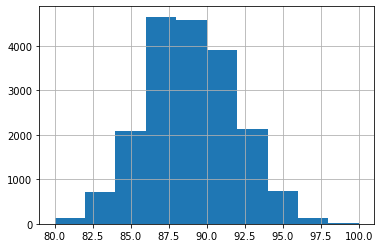

In [16]:
fig = data['points'].hist()
plt.show()

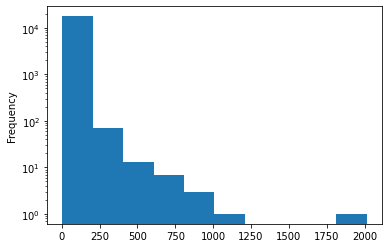

In [17]:
fig = data['price'].plot(kind = 'hist', logy=True)
plt.show()

In [18]:
data['price'][4]

66.0

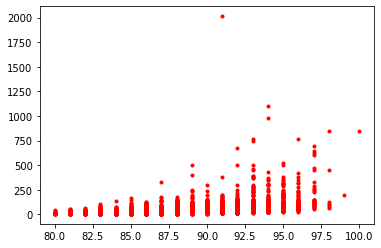

In [19]:
plt.plot(data['points'], data['price'], 'r.')

In [20]:
priceForPoint = data.groupby(by="points").mean()

In [21]:
#PriceForPoint donne la moyenne du prix de la bouteille pour un nbr de point donné

[]

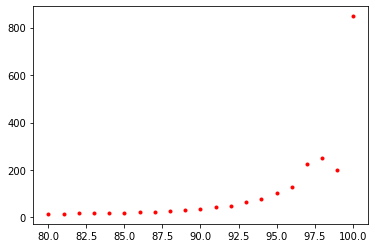

In [22]:
plt.plot(priceForPoint.index, priceForPoint , 'r.')
plt.plot()

[]

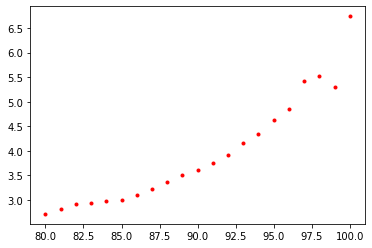

In [23]:
plt.plot(priceForPoint.index, np.log(priceForPoint) , 'r.')
plt.plot()

In [24]:
countries = data[ ["country", "winery"] ].groupby(by="country").count().sort_values(by="winery")[::-1]
countries.count()

winery    37
dtype: int64

In [25]:
data.index

RangeIndex(start=0, stop=19044, step=1)

In [26]:
data.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'variety', 'winery'],
      dtype='object')

In [27]:
countries_price = data[ ["country", "price"]].groupby(by ="country").mean()

In [28]:
data[data["country"]== 'Canada']["price"].mean()

29.88095238095238

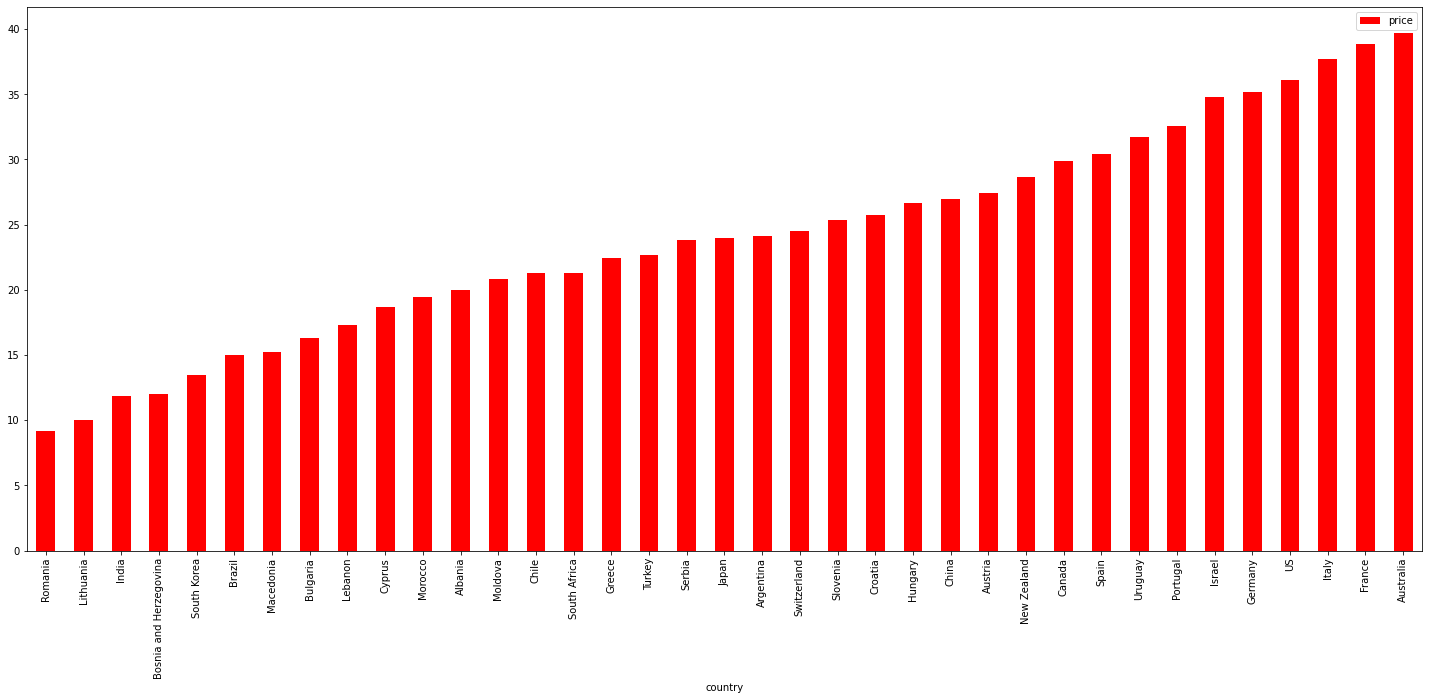

In [29]:
countries_price.sort_values('price').plot(kind = "bar", figsize = (25,10), color = 'red')

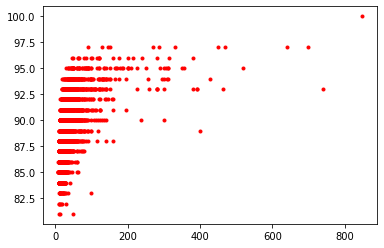

In [30]:
dfr=data[data["country"] == 'France']
plt.plot(dfr['price'],dfr['points'], 'r.')

In [31]:
dfr_max=dfr[dfr['price']> dfr['price'].quantile( q = 0.99)]

In [32]:
dfr_max=dfr_max[['region_1','winery']]

In [33]:
dfr_max.count()

region_1    28
winery      28
dtype: int64

In [34]:
dfr_max_winery = dfr_max.groupby('region_1').count().sort_values(by="winery")[::-1]
dfr_max_winery.head()

,winery
region_1,
Pessac-Léognan,3
Chambertin Clos de Bèze,3
Clos de Vougeot,2
Champagne,2
Chevalier-Montrachet,2


In [35]:
#Faisons un peu de RNN:

In [36]:
data.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [37]:
data_10000 = data.sample(frac = 0.1, random_state = 1)
X = data_10000['description']
Y = data_10000['points']

In [38]:
Y.mean()
Y.var()
print("Y n'est pas centrée On s'en occupe pour faciliter le traitement ensuite")

Y n'est pas centrée On s'en occupe pour faciliter le traitement ensuite


In [39]:
Y_corr= (Y-Y.mean())

In [40]:
mean=Y_corr.mean()
var=Y_corr.var()
print("Variance:",var, "Moyenne", mean)

Variance: 8.482642400102469 Moyenne -5.970947359328573e-16


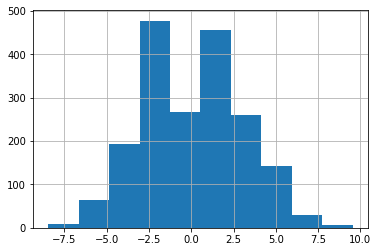

In [41]:
fig = Y_corr.hist()
plt.show()

In [42]:
#On va essayer de prédire, en fonction de la description, un score en séparant en 5 parties qui sera ensuite ramené sur 100.

In [43]:
groupe = (max(Y_corr)-min(Y_corr))/5
print("on va faire 5 catégories de taille", groupe+0.001)

on va faire 5 catégories de taille 3.601


In [80]:
maxLen = len(max(X, key=len).split())
maxLen

96

In [45]:
Y_corr = np.array(Y_corr)
mini = min(Y_corr)
for idx in range(len(Y_corr)):
    Y_corr[idx] = abs(Y_corr[idx] - mini)//4.001
    

In [46]:
Y_corr = np.array(Y_corr, dtype=int)
max(Y_corr)

4

In [47]:
def convert_to_one_hot(vecteur):
    oh = np.zeros((vecteur.size, int(vecteur.max()+1)))
    oh[np.arange(vecteur.size),vecteur] = 1
    return oh

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [49]:
X = np.array(X)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)

In [50]:
len(X)-len(X_train)

381

In [51]:
import csv

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [96]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [53]:
def sentence_to_avg(sentence, word_to_vec_map):
 
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    ### END CODE HERE ###
    
    return avg

In [54]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y) 
    
    print(Y_oh[:10])
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = - np.sum(Y_oh*np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [55]:
def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((50,))
        for w in words:
            while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [56]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
Epoch: 0 --- cost = 1768.6577045612125
Accuracy: 0.4891661195009849
Epoch: 100 --- cost = 1897.1636260517407
Accuracy: 0.5745239658568615
Epoch: 200 --- cost = 1987.8041944308302
Accuracy: 0.5797767564018385
Epoch: 300 --- cost = 2049.18288484555
Accuracy: 0.5837163493105713
[[2.]
 [2.]
 [2.]
 ...
 [1.]
 [1.]
 [2.]]


In [59]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.5791201575837164
Test set:
Accuracy: 0.5091863517060368


In [60]:
#On se retrouve avec une accuracy de 50... ce qui est mieux que le hasard (5 catégories) mais pas encore optimal
#On va utiliser un algo de LTSM pour pouvoir cette fois ci prendre en compte l'ordre des éléments dans la phrase

In [61]:
#Quelques test
idx = rd.randint(0,len(X))
X[idx],Y_corr[idx], idx

('From a seven-acre section of the vineyard, this offers plenty of saddle leather and cedar amidst spicy cardamom layers, a soft, juicy core and tingling acidity. The structure and weight suggest the ability to cellar comfortably through 2020.',
 3,
 339)

In [62]:
X_my_sentences = np.array(["I love that wine, it is so tasteful. A great success to see in the future"])
Y_my_labels = np.array([[3]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 1.0


array([[3.]])

In [67]:
X_my_sentences = np.array(["I love that wine , it is so tasteful. A great success !"])
Y_my_labels = np.array([[4]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 0.0


array([[3.]])

In [68]:
#Regardons à partir d'une matrice de confusion ce qui pose problème

In [69]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [70]:
Y_test.shape

(381,)

Predicted  0.0  1.0  2.0  3.0  All
Actual                            
0            4   29    3    1   37
1            4  111   44    1  160
2            0   69   76    1  146
3            0    8   26    3   37
4            0    0    1    0    1
All          8  217  150    6  381


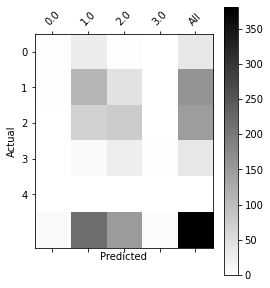

In [72]:
print(pd.crosstab(Y_test, pred_test.reshape(381,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [ ]:
#Problème : pas assez de '4' pour que l'algo le prédise..., les classes sont trop centrées sur 3 et 4. Il nous faut une refonte des groupes.

In [ ]:
quant = Y.quantile([0.2,0.4,0.6,0.8,1])

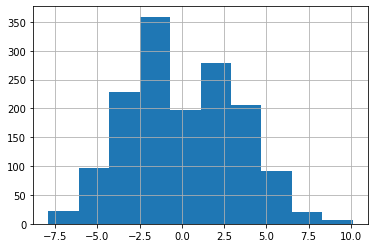

In [ ]:
data_1000 = data.sample(frac = 0.01, random_state = 1)
X = data_1000['description']
Y = data_1000['points']

Y_corr= Y-Y.mean()
quant = quant - Y.mean()
fig = Y_corr.hist()
plt.show()

Y_corr = np.array(Y_corr)
for idx in range(len(Y_corr)):
    if Y_corr[idx] <= quant[0.2]:
        Y_corr[idx] = 0
    elif Y_corr[idx] <= quant[0.4]:
        Y_corr[idx] = 1
    elif Y_corr[idx] <= quant[0.6]:
        Y_corr[idx] = 2
    elif Y_corr[idx] <= quant[0.8]:
        Y_corr[idx] = 3
    else:
        Y_corr[idx] = 4

In [ ]:
X = np.array(X)
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)


In [ ]:
pred, W_1, b_1 = model(X_train, Y_train, word_to_vec_map)
print(pred)

[[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]
Epoch: 0 --- cost = 1975.319195595971
Accuracy: 0.2444076222038111
Epoch: 100 --- cost = 2601.805941874836
Accuracy: 0.39188069594034797
Epoch: 200 --- cost = 2660.0546527054967
Accuracy: 0.4009942004971003
Epoch: 300 --- cost = 2670.3054980463667
Accuracy: 0.4009942004971003
[[2.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W_1, b_1, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W_1, b_1, word_to_vec_map)


Training set:
Accuracy: 0.4067937033968517
Test set:
Accuracy: 0.3344370860927152


Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0           55   10    0    4    2   71
1           34   18    2    3    5   62
2           23   18    3    9   12   65
3           14   19    5    8   13   59
4            5   12    4    7   17   45
All        131   77   14   31   49  302


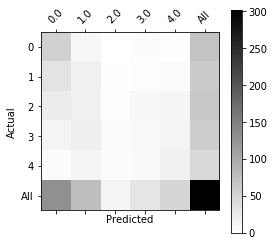

In [ ]:
print(pd.crosstab(Y_test, pred_test.reshape(302,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [ ]:
#Mieux que le hasard certes mais toujours pas fou, on va tenter le LSTM

In [73]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [149]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        print(i)
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
          while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            # Set the (i,j)th entry of X_indices to the index of the correct word.
          X_indices[i, j] = word_to_index[w]
          j += 1
            
    
    return X_indices

In [150]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim )
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [151]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [152]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense( units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [153]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 96, 50)            20000050  
_________________________________________________________________
lstm_10 (LSTM)               (None, 96, 128)           91648     
_________________________________________________________________
dropout_10 (Dropout)         (None, 96, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)               

In [154]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

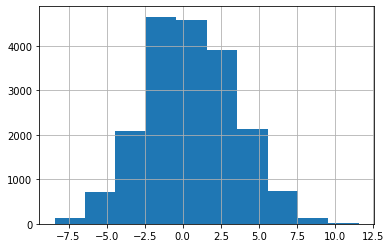

In [155]:
data_10000 = data.sample(frac = 0.1, random_state = 1)
X = data['description']
Y = data['points']
Y_corr= (Y-Y.mean())
quant = Y.quantile([0.2,0.4,0.6,0.8,1])
quant = quant - Y.mean()
fig = Y_corr.hist()
plt.show()

Y_corr = np.array(Y_corr)
for idx in range(len(Y_corr)):
    if Y_corr[idx] <= quant[0.2]:
        Y_corr[idx] = 0
    elif Y_corr[idx] <= quant[0.4]:
        Y_corr[idx] = 1
    elif Y_corr[idx] <= quant[0.6]:
        Y_corr[idx] = 2
    elif Y_corr[idx] <= quant[0.8]:
        Y_corr[idx] = 3
    else:
        Y_corr[idx] = 4


In [156]:
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)

In [157]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyError: ignored

In [158]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

NameError: ignored

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)